# Energy consumption of a Web Application Implemented in Different Programming Languages and Web Frameworks
*Probabilistic Programming 2025 Exam by Raúl Pardo ([raup@itu.dk](mailto:raup@itu.dk)) and Andrzej Wąsowski ([wasowski@itu.dk](mailto:wasowski@itu.dk))*<br/>
*version 1.0.0 2025-03-20 08:40*


In this exam, your task is to analyze energy consumption of different implementations of a web application.
The goal is to determine whether there are differences in energy consumption in different implementations of the web application or in its API endpoints.
This analysis is of utmost importance, as it might help software engineers to make informed choices that lower energy consumption. For instance, a plausible hypothesis is that lower level programming languages such as Rust consume less energy than higher level languages such as Python.
A preconception in this domain is that running time is the driving factor in energy consumption.
Are these true? The data in this exam and the analysis you will develop will allow to answer this type of questions.

## Data

The dataset contains $N = 1960$ measurements of energy consumption for different implementations and functionality of a web application. For each setup, there are 20 measurements. The dataset is in the file [dataset.csv](dataset.csv). The variables in the dataset are:

* **Application**. This variable has the form `<programming_language>-<web_framework>`. It specifies the programming language and web framework used in the experiment. For instance, `rust-actix` denotes the web framework Actix for the programming language Rust, or `c-sharp-razor` denotes the web framework Razor for the programming language C#.
    * Note that if a hypothesis involves only programming language, you need to extract it from the values in this variable.

* **Endpoint**. This variable refers to the API endpoints of the web application. For example, `/api/register` refers to the API endpoint used for registering users in the web application, or `/logout` is used for logging out of the system.

* **Runtime**. This variable indicates the time it took to process the request to the endpoint in seconds.

* **Energy consumption**. This variable indicates the energy consumed for processing the request to the endpoint in Joules.

Each row in the dataset is a measurement of the total energy consumed and runtime after processing a request in the corresponding API endpoint. The *Application* variable in each row indicates the web framework used for the measurement.

## Hypotheses

To analyze energy consumption in the different implementations, you must investigate the following hypotheses:

* **H1** - The web framework `c-sharp-razor` consumes more energy than any other web framework in the dataset.

* **H2** - The programming language `javascript` consumes the least amount of energy compared to any other programming language in the dataset.

* **H3** - Runtime has a stronger impact on energy consumption for some API endpoints than others. That is, the effect of runtime on energy consumption is larger for some API endpoints than others.

Your task is to use Bayesian Inference and Regression to decide whether these hypotheses hold, or possibly reject them. This includes:

* Loading, restructuring and transforming the data as needed.

* Designing Bayesian regression models and using inference algorithms to test the above hypotheses in PyMC.

* Explaining your model idea in English, preferably using a figure, and showing the Python code.

* Checking and reflecting (in writing) on the quality of the sampling process, considering warnings from the tool, sampling summary statistics, trace plots, and autocorrelation plots. Comment whether the quality of the sampled trace is good, and whether you had to make any adjustments during modeling and/or sampling.

* Visualizing the posterior information appropriately to address the hypotheses.
  

You should hand in a zip file with a Jupyter notebook and the data file (so that we can run it), and a **PDF file rendering of the Jupyter notebook**, so that your work can be assessed just by reading this file. It appears that the best PDF rendering is obtained by File / Export to HTML, and then saving/printing to PDF from your browser.

Make sure the notebook is actually a **report** readable to the examiners, especially to the censor who has not followed the course. The report should include:
* A brief introduction.
* Explanations on how data is loaded and cleaned.
* Explanations on analysis and model design (for each of the models you consider).
* A discussion of sampling quality (for each model) and all the plots that you present, and a reflection/decision on the outcome for each hypothesis.
* An overall conclusion.

**IMPORTANT:** For the tasks below, your code must accompany an explanation of its meaning and intended purpose. **Source code alone is not self-explanatory**. As mentioned above, you should also reflect on the results you get, e.g., highlighting issues with the data, or issues, pitfalls and assumptions of a model. **Exams containing only source code or very scarce explanations will result in low grades, including failing grades.**





## Minimum requirements 

1. Design a regression model to predict energy consumption using web framework as a predictor.
  
2. Analyze hypothesis H1 using the regression model in (1.).

## Ideas for extension

**Groups aiming at grade 7 and more should complete the following tasks:**
    
3. Analyze hypothesis H2, if necessary design a new model.
        
4. Perform prior predictive checks in all your models. Explain why the priors you selected are appropriate.
    
5. Perform posterior predictive checks in all your models. Discuss the results in the posterior predictive checks.
    
6. Discuss trace convergence in all your models.
    
**Groups aiming at grade 10 and higher should try 3-5 ideas from below or add some of your own:**

7. Analyze hypothesis H3, if necessary design a new model.
    
8. Perform a counterfactual analysis in your model for H3: For each endpoint, plot posterior predictions on energy consumption for a runtime value much larger than those in the dataset. Does this affect/introduce differences between energy consumption for different endpoints?
    
9. Design models with a transformation of the predicted variable, i.e., energy consumption. For instance, 
    * Build a model to analyze the probability that the energy consumption of a web framework is below 0.4 Joules. You may consider versions of this task involving other predictors.
    * Transform energy consumption into an ordinal variable representing an energy mark, e.g., an energy consumption in 0.0-0.2 is energy mark A, energy consumption in 0.2-0.4 is energy mark B and energy consumption of ≥ 0.4 is energy mark C. Use an ordinal regression model to analyze the energy mark of each framework. You may consider versions of this task involving other predictors.
    
10. Use information criteria to compare the models to analyze H1, H2 and H3.
    
11. Design a meaningful multilevel model in the context of these data.
   
12. Use causal reasoning to analyze causal relations between the variables in the dataset.

---

In [2]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('dataset.csv')

In [67]:
language, framework = list(zip(*df["application"].apply(lambda a: a.split("-") if not a.startswith("c-sharp") else [a[0:7], a[8:]])))
df["language"] = list(language)
df["framework"] = list(framework)

In [68]:
df

,application,endpoint,energy_consumption,runtime,language,framework
0,rust-actix,/api/register,0.449358,0.148812,rust,actix
1,rust-actix,/api/register,0.433871,0.148895,rust,actix
2,rust-actix,/api/register,0.270844,0.094729,rust,actix
3,rust-actix,/api/register,0.479776,0.163467,rust,actix
4,rust-actix,/api/register,0.268833,0.092300,rust,actix
...,...,...,...,...,...,...
1955,javascript-express,/logout,0.096436,0.032214,javascript,express
1956,javascript-express,/logout,0.097559,0.032214,javascript,express
1957,javascript-express,/logout,0.096922,0.032214,javascript,express
1958,javascript-express,/logout,0.097086,0.032214,javascript,express


Let's try to understand the data a little better.

/tmp/ipykernel_33017/1298083601.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(grouped, labels=labels, patch_artist=True)


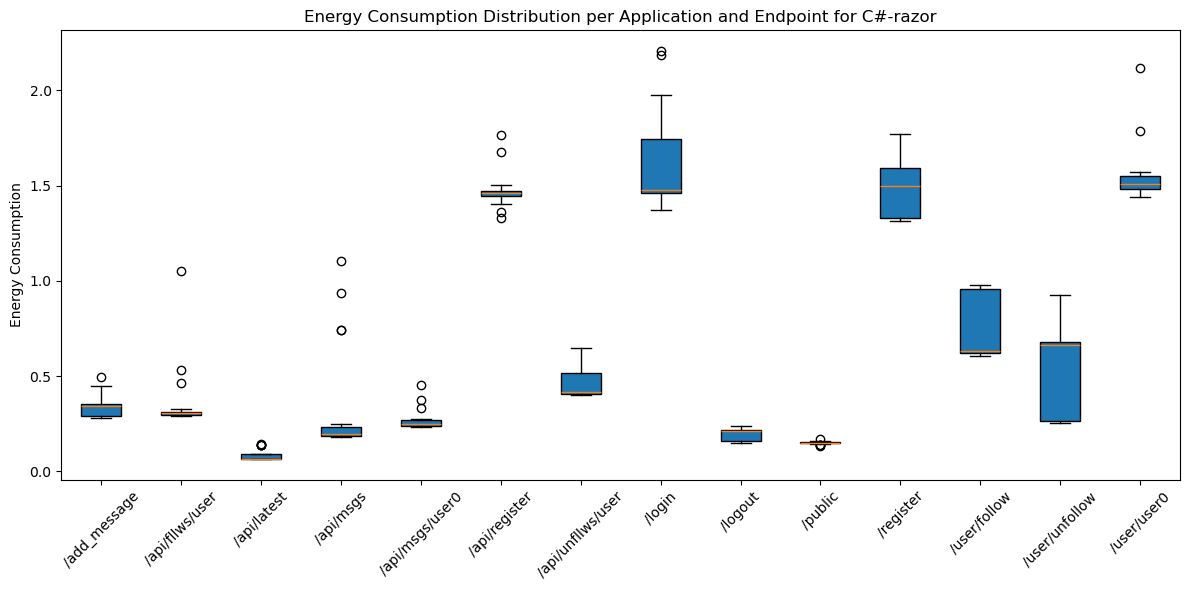

In [ ]:
csharpdata = df.where(df["application"] == "c-sharp-razor")
data = csharpdata
grouped = [ group["energy_consumption"].values for _, group in data.groupby(["endpoint"]) ]
labels = data.groupby(["endpoint"]).groups.keys()

plt.figure(figsize=(12, 6))
plt.boxplot(grouped, labels=labels, patch_artist=True)
plt.title("Energy Consumption Distribution per Application and Endpoint for C#-razor")
plt.ylabel("Energy Consumption")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


What a beautiful plot. But there seems to be some clear variance between consumption in endpoints within the same application.


##### Testing H1

The first step will be to create a simple model with a single intercept per application. We will treat application as a categorical value. From here on we will refer to application A and consumption C.

Let's build a simple model:
$$
\begin{aligned}
    C &\sim \text{Normal}(\mu, \sigma) \\
    \mu &\sim \alpha_{[A[i]]} \\
    \alpha &\sim \text{Normal}(0,10) \\
    \sigma &\sim \text{Exponential}(1)
\end{aligned}
$$

We defined the prior for $\alpha$ as an extremely flat $\text{Normal}$ distribution because we don't have much prior knowledge of the energy consumption of different programming language and framework pairs.

The first step will be to create categorical values for the application column of the data:

In [78]:
cats = pd.Categorical(df["application"])
df["A"] = cats.codes
"c-sharp-razor code: ", cats.codes[cats == "c-sharp-razor"][0]

('c-sharp-razor code: ', 0)

Here we see that value 0 is "*c-sharp-razor*". We are now ready to create the PYMC model:

/home/chobbie/anaconda3/envs/prpro-2025/lib/python3.12/site-packages/pymc/data.py:440: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


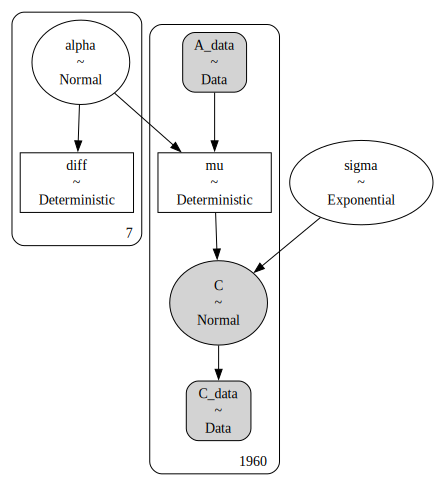

In [105]:
with pm.Model() as m_h1a:
    alpha = pm.Normal("alpha", 0, 10, shape=df["A"].unique().size)
    sigma = pm.Exponential("sigma", 1)

    C_data = pm.Data("C_data", df["energy_consumption"].values, mutable=True)
    A_data = pm.Data("A_data", df["A"].values, mutable=True)

    mu = pm.Deterministic("mu", alpha[A_data])
    C = pm.Normal("C", mu, sigma, observed=C_data)

    diff = pm.Deterministic("diff", alpha - alpha[0])

    trace_h1a = pm.sample()
pm.model_to_graphviz(m_h1a)


In [106]:
az.summary(trace_h1a, var_names=["alpha", "diff"])

/home/chobbie/anaconda3/envs/prpro-2025/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.690,0.015,0.661,0.718,0.0,0.0,7065.0,3219.0,1.0
alpha[1],0.319,0.016,0.289,0.348,0.0,0.0,5583.0,2978.0,1.0
alpha[2],0.324,0.016,0.294,0.353,0.0,0.0,5799.0,3274.0,1.0
alpha[3],0.206,0.016,0.177,0.237,0.0,0.0,4469.0,3274.0,1.0
alpha[4],0.413,0.016,0.382,0.443,0.0,0.0,5125.0,2847.0,1.0
alpha[5],0.409,0.016,0.380,0.438,0.0,0.0,4562.0,3166.0,1.0
alpha[6],0.307,0.016,0.280,0.338,0.0,0.0,5289.0,3176.0,1.0
diff[0],0.000,0.000,0.000,0.000,0.0,0.0,4000.0,4000.0,NaN
diff[1],-0.370,0.022,-0.412,-0.327,0.0,0.0,6216.0,3361.0,1.0
diff[2],-0.365,0.022,-0.403,-0.323,0.0,0.0,6798.0,3265.0,1.0


Looking at the summary of the simulation, firstly we see that the $\hat r$ values are all 1, meaning the simulation was successful (and similarly the effective sample size (ess_bulk) is also high). Interestingly, considering only the alpha parameters, we see that the mean $\alpha$ is highest for the category "*c-sharp-razor*", and the model is fairly confident (low standard deviation).

Let's take a closer look at the "diff" which in this model is the contrast to the baseline, application "*c-sharp-razor*".

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

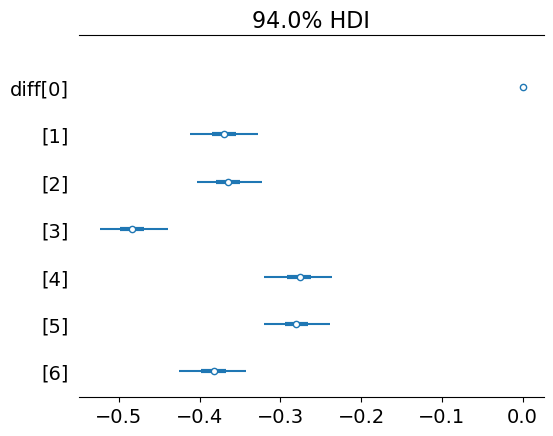

In [108]:
az.plot_forest(trace_h1a, var_names=["diff"], combined=True)

Recall that $0$ (zero) is the application "*c-sharp-razor*". We see from the forest plot of contrasts above that they are all sitting well to the left of 0.0, meaning that the energy consumption of "*c-sharp-razor*" is higher than all the other language/frameworks. We are able to reject hypothesis 1.

There is certainly a point to be made about the chocice of $\text{Normal}$ distribution. We could've chosen the $\text{Student-T}$ distribution to better accommedate potential outliers that may happen as a result of garbage collectors etc.

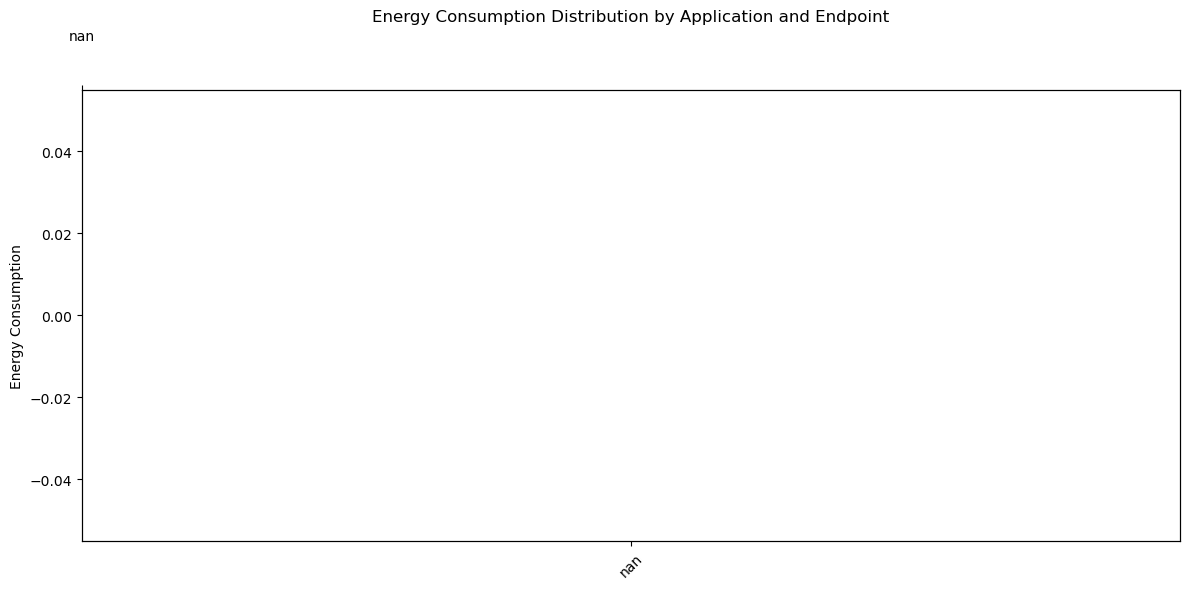

In [92]:
df_sorted = df.where(df["application"] == "c-sharp-reazor").sort_values(by=["application", "endpoint"])
df_sorted["label"] = df_sorted["endpoint"]  # keep only endpoint in label

# Group data
grouped = df_sorted.groupby(["application", "endpoint"])
data = [group["energy_consumption"].values for _, group in grouped]
labels = [endpoint for (app, endpoint) in grouped.groups.keys()]
apps = [app for (app, endpoint) in grouped.groups.keys()]

# Plot boxplot
fig, ax = plt.subplots(figsize=(12, 6))
box = ax.boxplot(data, patch_artist=True)

# Set endpoint labels (first row)
ax.set_xticks(range(1, len(labels) + 1))
ax.set_xticklabels(labels, rotation=45)

# Now add application labels above/below grouped endpoint labels
prev_app = None
tick_positions = []
tick_labels = []
start = 1

for i, app in enumerate(apps + ["__end__"]):  # add dummy to detect last group
    if app != prev_app and prev_app is not None:
        end = i
        pos = (start + end - 1) / 2
        tick_positions.append(pos)
        tick_labels.append(prev_app)
        start = i
    prev_app = app

# Add application labels as a second row of labels
ax2 = ax.twiny()
ax2.set_xticks(tick_positions)
ax2.set_xticklabels(tick_labels, fontsize=10)
ax2.set_xlim(ax.get_xlim())
ax2.tick_params(axis='x', pad=30)  # push labels down

# Titles and formatting
plt.title("Energy Consumption Distribution by Application and Endpoint")
ax.set_ylabel("Energy Consumption")
plt.tight_layout()
plt.show()

In [ ]:
df.endpoint.unique().size

14

In [41]:
df.application.unique().size

7